# How to create a TB simulation

## High level steps

As suggested by the starsim 'Getting Started' tutorial (https://docs.idmod.org/projects/starsim/en/latest/tutorials/tut_intro.html) we will proceed with the most common tasks for modeling infectious diseases, in our case, TB:

1. Defining parameters (Building the simulation):
2. Running a simulation 
3. Plotting results



This notebook demonstrates how to create and run simulations for tuberculosis (TB) using the `tbsim` and `starsim` libraries. The simulations will model the spread and impact of TB over time on a population.


## Packages

The code in this section imports the `starsim` package, which provides the capabilities to create and run simulations.
Note that while `tbsim` enables some functionality, the full capabilities are provided by `starsim`.


In [1]:

# Import necessary libraries
import tbsim
import starsim as ss
import matplotlib.pyplot as plt
import numpy as np



## Building the simulation

In this case, in order to make our code reusable  we will encapsulate all our preparation steps in the following function, `make_tb`. This function puts together all what is needed for a simulation to run and returns a <b style="color: gold; "> simulation object</b> with a tuberculosis disease, methods, etc., and with user specified parameters. NOTE: Default values are generally specified as part of the __init__ method for each class, i.e. people, network, tb, etc.).



### People:
- Creates a population of 1,000 agents using the People class from the starsim (aliased as ss) library.

### TB Disease
- Defines the disease parameters for TB:
    - beta: Transmission rate (default: 0.025 per year using ss.peryear()).
    - init_prev: Initial prevalence of TB (default: 10% using ss.bernoulli()).
- Initializes the TB model with these parameters using the tbsim library.
- The TB class includes comprehensive disease progression with multiple states: latent (slow/fast), active (pre-symptomatic, smear positive/negative, extra-pulmonary), and treatment effects.

### Network
- Defines the network parameters:
    - n_contacts: Number of contacts per agent, following a Poisson distribution with a mean (lambda) of 5.
    - dur: Duration of contact (0 means end after one timestep).
- Initializes a random network with these parameters.

### Demographics

The demographics section sets up two demographic processes for the simulation: pregnancy and death rates. These, define and incorporate key demographic events into the simulation model:

- **Pregnancy**: Adds new agents to the population at a rate of 25 per 1,000 people. (TODO: Verify if this is done every time every step or if this is a one time event at set_prognoses)
- **Deaths**: Removes agents from the population at a rate of 10 per 1,000 people. (same question as above)

This setup ensures the simulation realistically accounts for population changes over time due to births and deaths.

### Simulation Parameters and Initialization

This part of the code defines the parameters for the simulation and initializes it using these parameters:

1. **Defining Simulation Parameters**:
    - **`dt = ss.days(7)`**: This defines the time step (`dt`) for the simulation. Here, `ss.days(7)` represents a weekly time step, so the simulation progresses in weekly increments.
    - **`start = ss.date(1990,1,1)`**: This sets the starting date of the simulation to January 1, 1990.
    - **`stop = ss.date(2020,1,1)`**: This sets the ending date of the simulation to January 1, 2020.

2. **Initializing the Simulation**:
    - **`ss.Sim`**: This is a class from the `starsim` package used to create a simulation object.
    - **Parameters**:
        - **`people=pop`**: Specifies the population object created earlier.
        - **`networks=net`**: Specifies the network object that describes how agents are connected.
        - **`diseases=tb`**: Specifies the TB disease model initialized earlier.
        - **`pars=sim_pars`**: Passes the simulation parameters defined above.
        - **`demographics=dems`**: Specifies the list of demographic events (pregnancy and death rates).

3. **Setting Verbosity**:
    - This line adjusts how frequently the simulation prints its status updates.
    - **`sim.pars.verbose = 0`**: This sets the verbosity to 0, which means no status updates will be printed during the simulation run.

4. **Returning the Simulation Object**:
    - This returns the initialized simulation object so that it can be run or further interacted with outside of the `make_tb` function.



In [2]:
# Define the function to create a tuberculosis simulation
def make_tb():
    # --------------- People ----------
    initial_population_size = 1000
    pop = ss.People(n_agents=initial_population_size)
    
    # --------------- TB disease --------
    # Using current default parameters from TB class
    tb_pars = dict(  # Disease parameters
        beta = ss.peryear(0.025),  # Updated to match current default
        init_prev = ss.bernoulli(0.10),  # 10% initial prevalence
        )
    tb = tbsim.TB(tb_pars) # Initialize

    # --------------- Network ---------
    net_pars = dict(    # Network parameters
        n_contacts=ss.poisson(lam=5),
        dur = 0, # End after one timestep
        )
    net = ss.RandomNet(net_pars)  # Initialize a random network

    # --------------- Demographics --------
    dems = [
        ss.Pregnancy(pars=dict(fertility_rate=25)), # Per 1,000 people
        ss.Deaths(pars=dict(death_rate=10)), # Per 1,000 people
    ]

    # --------------- simulation -------
    sim_pars= dict(
        dt = ss.days(7),
        start = ss.date(1990,1,1),
        stop = ss.date(2020,1,1),
        )
    sim = ss.Sim(people=pop, 
                 networks=net, 
                 diseases=tb, 
                 pars=sim_pars, 
                 demographics=dems
                 )   # initialize the simulation
    sim.pars.verbose = 0 # Print status every 100 steps
    return sim



### Run the Simulation

We will now create and run the first simulation using the `make_tb` function with the parameters set above. 

Please note, at some point it may be convenient to parameterize the `make_tb` function and make it even more re-usable (for intance for scenarios creation).


In [3]:

# Create and run the first simulation
sim = make_tb()  # Create the simulation - running make_tb returns a simulation of a type ss.Sim (from starsim library) therefore we can use all the methods of the ss.Sim class
sim.run()        # Run the simulation 


Sim(n=1000; 1990.01.01—2020.01.01; demographics=pregnancy, deaths; networks=randomnet; diseases=tb)

## Analyzing The Results


Let's first review the data that was generated (and is available in the results array). This collected data is specified in the `init_results()` method and then updated in the `update_results()` method of the TB class. The results include:

- **State counts**: Number of individuals in each TB state (latent, active, infectious)
- **Age-specific metrics**: Separate tracking for individuals 15+ years old
- **Incidence and mortality**: New cases, deaths, and cumulative measures
- **Epidemiological indicators**: Prevalence, incidence rates, and detection metrics

For more detailed information, please refer to the official documentation at [StarSim Results API](https://docs.idmod.org/projects/starsim/en/latest/api/_autosummary/starsim.results.Result.html).

In [4]:
tbr = sim.diseases['tb'].results

print("This is a dictionary of the results that you can plot: \n",tbr.keys())


This is a dictionary of the results that you can plot: 
 ['timevec', 'n_susceptible', 'n_infected', 'n_on_treatment', 'n_ever_infected', 'prevalence', 'new_infections', 'cum_infections', 'n_latent_slow', 'n_latent_fast', 'n_active', 'n_active_presymp', 'n_active_presymp_15+', 'n_active_smpos', 'n_active_smpos_15+', 'n_active_smneg', 'n_active_smneg_15+', 'n_active_exptb', 'n_active_exptb_15+', 'new_active', 'new_active_15+', 'cum_active', 'cum_active_15+', 'new_deaths', 'new_deaths_15+', 'cum_deaths', 'cum_deaths_15+', 'n_infectious', 'n_infectious_15+', 'prevalence_active', 'incidence_kpy', 'deaths_ppy', 'n_reinfected', 'new_notifications_15+', 'n_detectable_15+']


now, below we show the plotting of a single channel (result):

Text(0.5, 1.0, 'The most basic plotting sample \n TB Prevalence \n (raw data)')

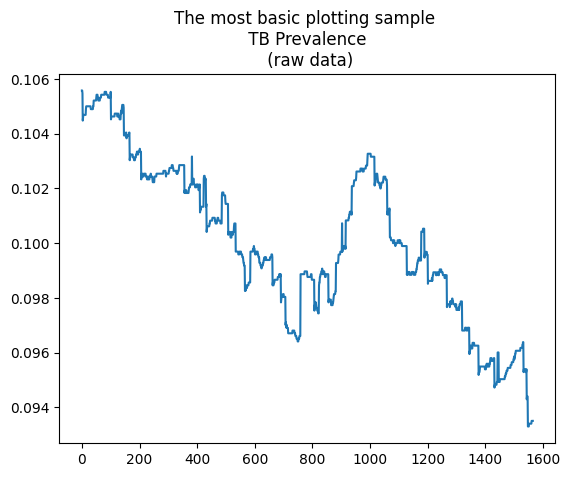

In [5]:

plt.plot(range(0,len(tbr['prevalence'])),tbr['prevalence'])
plt.title("The most basic plotting sample \n TB Prevalence \n (raw data)")



## <h1 style="color: orange; ">Plotting</h1>
<p>Once you get familiar with the available data in the results array, you can proceed to plot your results using your favorite method.</p>

### <h3 style="color: lightblue; ">1: Using the starsim library</h3>
<p>Plot the results of the simulation - inherited from the starsim library which is available under the diseases attribute of the simulation: <code> sim.plot() </code> </p>



Figure(1200x900)


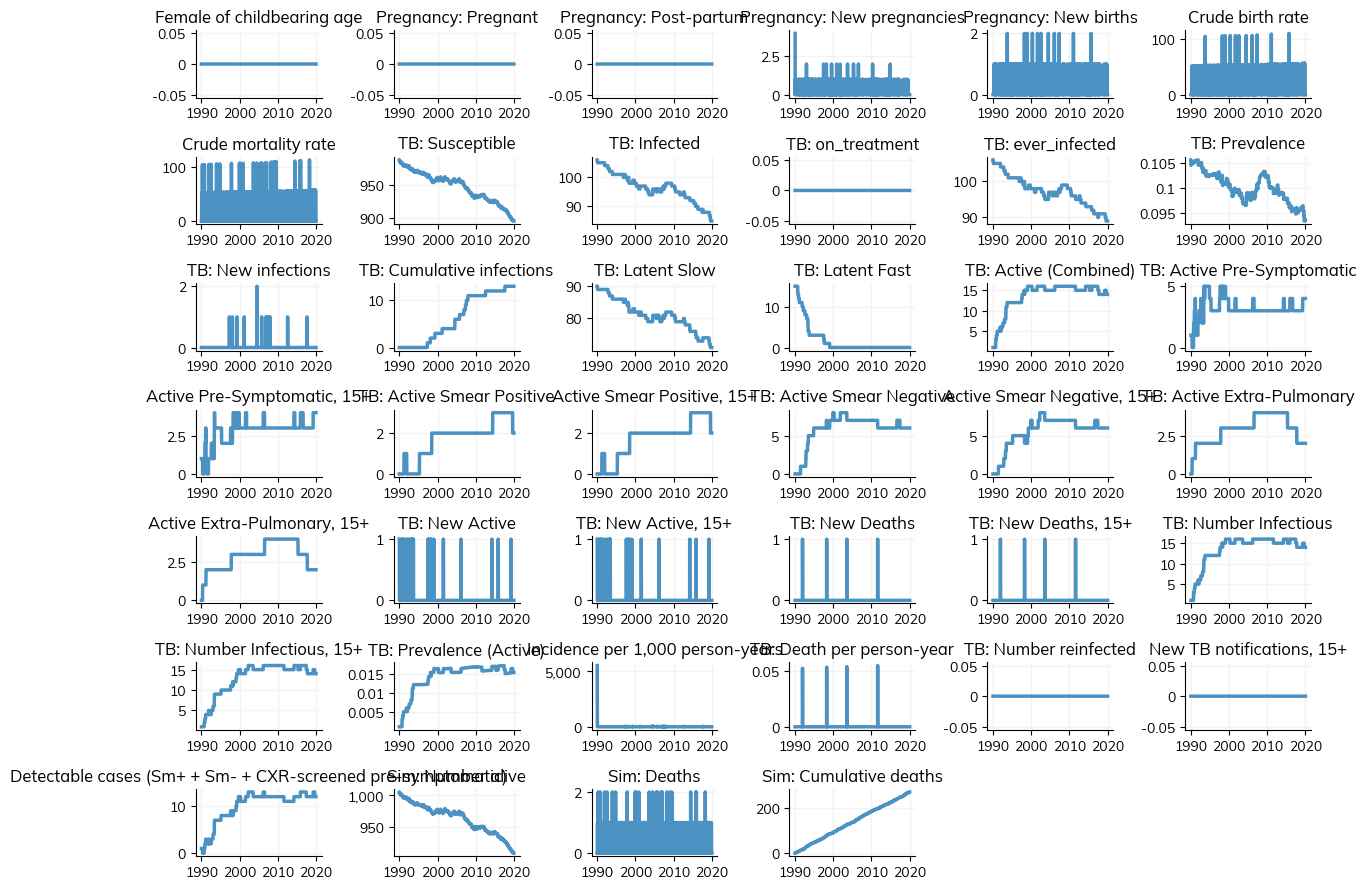

In [6]:
sim.plot()

### Using TBSim plots:
The `plot_combined` function from tbsim can be used to create comprehensive plots:
```python
tbsim.plot_combined({'single simulation': sim.results.flatten(), 'tb only results': sim.diseases['tb'].results.flatten()})
```
where each key represents a scenario that will be plotted with a different color.

For more information, see the `plot_combined` function documentation.


Saved figure to /Users/mine/newgit/newtbsim/docs/tutorials/results/scenarios_20250907_222603.png


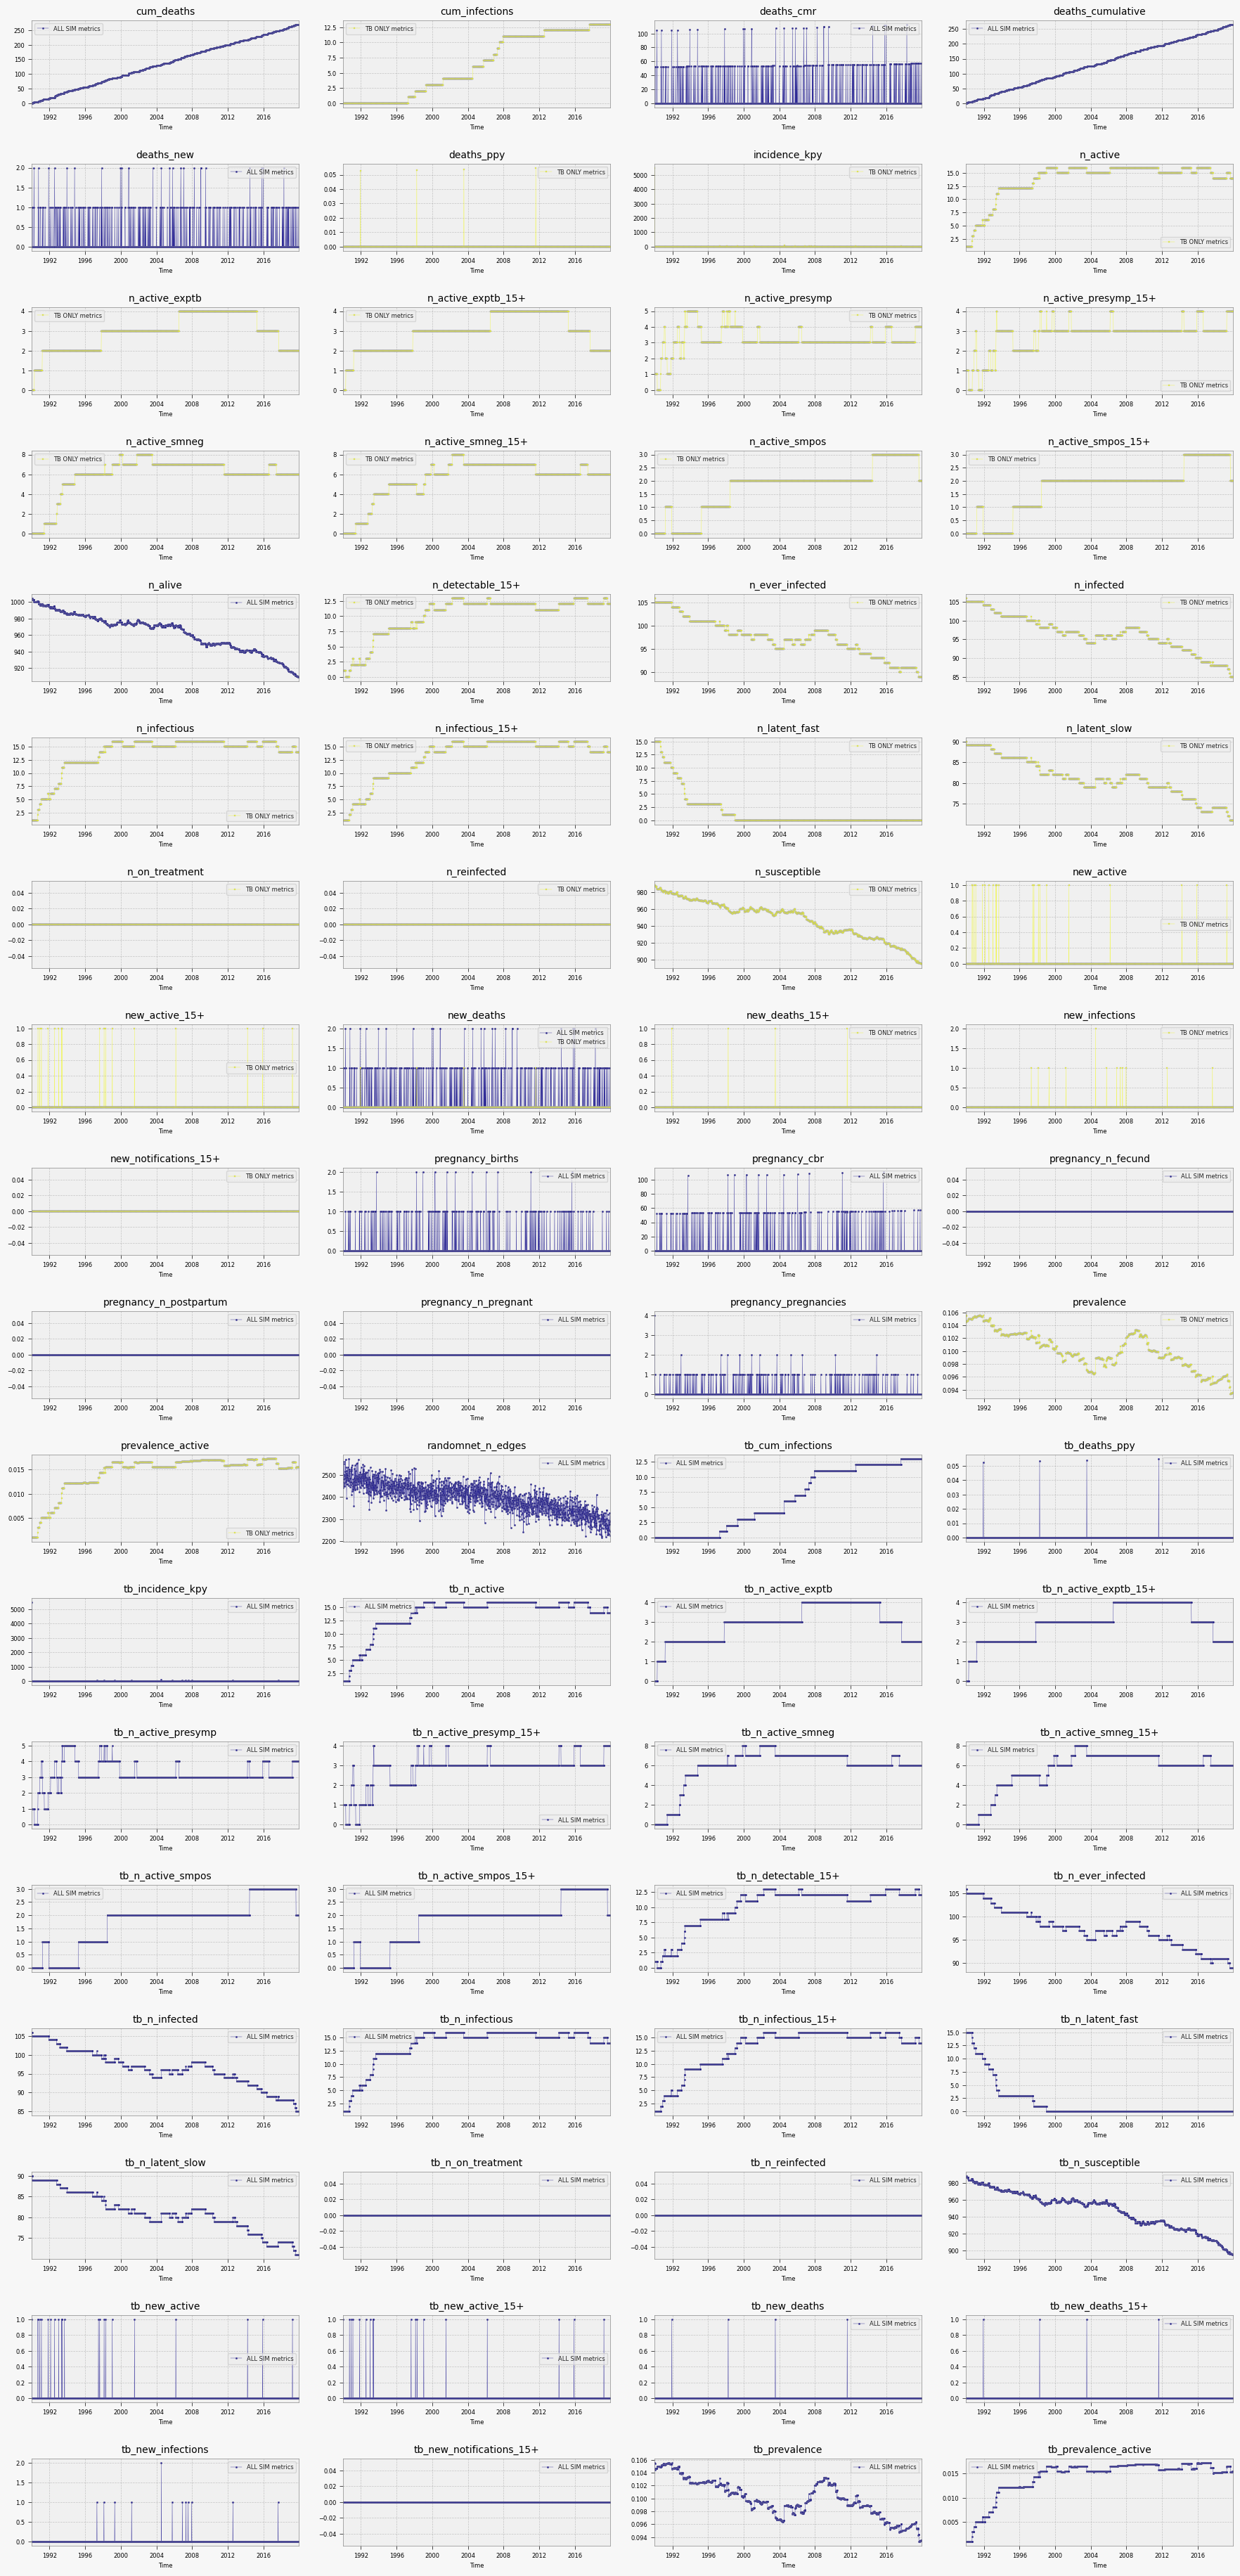

In [7]:
# Create comprehensive plots using tbsim's plot_combined function
tbsim.plot_combined({'ALL SIM metrics': sim.results.flatten(),'TB ONLY metrics': sim.diseases['tb'].results.flatten()}, dark=False, n_cols=4, heightfold=2 )


### Using your own function

Take a look at the sample below, it will show you how to access the results dataframe (dict) and how with a simple function you can plot your simulation's results.

Text(0, 0.5, 'Number of Individuals')

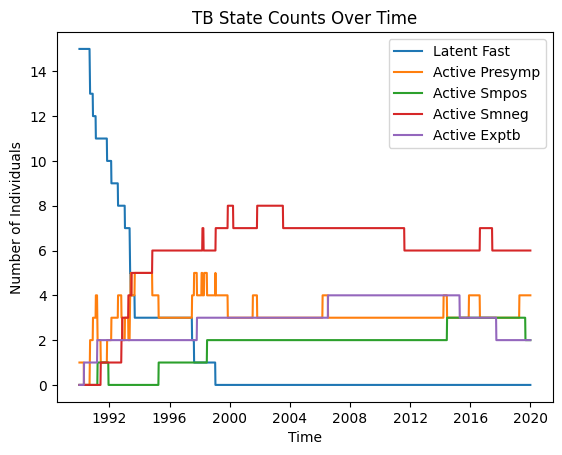

In [8]:

# Method 3: Custom plotting using TB results directly
fig = plt.figure()
tb_results = sim.diseases['tb'].results
for rkey in ['n_latent_fast', 'n_active_presymp', 'n_active_smpos', 'n_active_smneg', 'n_active_exptb']:
    plt.plot(tb_results['timevec'], tb_results[rkey], label=rkey.replace('n_', '').replace('_', ' ').title())
plt.legend()
plt.title("TB State Counts Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Individuals")


## Additional Information

### Current TB Model Features

The TB model in this notebook uses the latest implementation from the `tbsim` library, which includes:

- **Comprehensive Disease States**: The model tracks multiple TB states including latent (slow/fast progression), active (pre-symptomatic, smear positive/negative, extra-pulmonary), and treatment effects.

- **Realistic Parameters**: Default parameters are based on epidemiological literature and include:
  - Transmission rate: 0.025 per year
  - Initial prevalence: 10% of population (as used in this tutorial)
  - State-specific progression rates and mortality
  - Treatment effects on transmission and mortality

- **Age-Specific Tracking**: Separate metrics for individuals 15+ years old, important for TB epidemiology.

- **Treatment Integration**: The model includes treatment effects that reduce transmission and prevent mortality.

### Next Steps

To extend this simulation, you can:
1. Add interventions (diagnostics, treatment programs, vaccination)
2. Include comorbidities (HIV, malnutrition)
3. Modify network structures (household networks, spatial networks)
4. Run scenario analyses with different parameter sets
5. Use the comprehensive analyzers for detailed epidemiological analysis

For more advanced examples, see the other tutorials in this documentation.
